# CajaMar University Hack 2023

La Viña Wine Prediction

Ana Cardells

## Install

In [ ]:
# pip install xgboost

## Imports

In [1]:
from datetime import datetime
from scipy.stats import randint, uniform
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AffinityPropagation
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, GammaRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectPercentile
from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.tree import plot_tree
from sklearn.base import BaseEstimator, TransformerMixin

## Creacion de funciones de apoyo

In [2]:
def metricas(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("RMSE: {:.2f}".format(mse**(1/2)))
    print("R2 score: {:.2f}".format(r2))

metricas_eval = {
  'RMSE': make_scorer(lambda y, y_pred:
                      sqrt(mean_squared_error(y, y_pred)),
                      greater_is_better=False),
  'R2': 'r2'
  }

In [3]:
def plot_bisectriz(y, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Valor real de la clase')
    ax.set_ylabel('Predicción')
    plt.grid()
    plt.show()

## Carga de datos y Modelado


In [10]:
# Cargar datos de viñedos y temperatura
df_train = pd.read_csv('UH_2023_TRAIN_alt.txt', sep="|")   # UH_2023_TRAIN_alt_sup
df_meteo = pd.read_csv('DATOS_METEO_MES.txt', sep="|")

# Unir datasets
df = pd.merge(df_train, df_meteo, on=['CAMPAÑA', 'ID_ESTACION'])

# Eliminar datos de 2022 (con estos se hara finalmente la prediccion final)
df = df[df['CAMPAÑA'] != 22]

# Separar datos de train y test (se usaran los datos de 2021 para el test)
df_train = df[df['CAMPAÑA'] != 21]
df_test = df[df['CAMPAÑA'] == 21]

# Separar X/y
X_train = df_train.drop(['PRODUCCION'], axis=1)
y_train = df_train['PRODUCCION']
X_test =  df_test.drop(['PRODUCCION'], axis=1)
y_test = df_test['PRODUCCION']

# Eliminar columnas no necesarias
X_train = X_train.drop(['CAMPAÑA', 'ID_ESTACION', 'ID_FINCA', 'ID_ZONA'], axis=1)
X_test = X_test.drop(['CAMPAÑA', 'ID_ESTACION', 'ID_FINCA', 'ID_ZONA'], axis=1)

In [11]:
# Normalizar datos
col_total = X_train.columns
lista_cat = ['VARIEDAD', 'MODO','TIPO','COLOR']
col_categoricas = [x for x in col_total if x in lista_cat]
col_numericas = [x for x in col_total if x not in lista_cat]

# One hot encoding
onehot_df_train = X_train[col_categoricas]
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(onehot_df_train)
X_train_encoded = encoder.transform(onehot_df_train)
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(col_categoricas))
X_train_drop = X_train.drop(col_categoricas, axis=1)
X_train = pd.concat([X_train_drop, X_train_encoded_df], axis=1)

# Split train y val
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)   # Por defecto es shuffle True

# escalando las variables numéricas
scaler=StandardScaler()
X_tr[col_numericas] = scaler.fit_transform(X_tr[col_numericas])
X_val[col_numericas] = scaler.transform(X_val[col_numericas])

In [42]:
# Definir y entrenar el modelo
reg = xgb.XGBRegressor(
    eval_metric = 'rmse',
    max_depth=5,
    min_child_weight=5,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42)

reg.fit(X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        verbose=50)

[0]	validation_0-rmse:14262.25277	validation_1-rmse:13308.13451
[50]	validation_0-rmse:9852.32210	validation_1-rmse:10204.31863
[99]	validation_0-rmse:9395.10944	validation_1-rmse:10213.86569


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

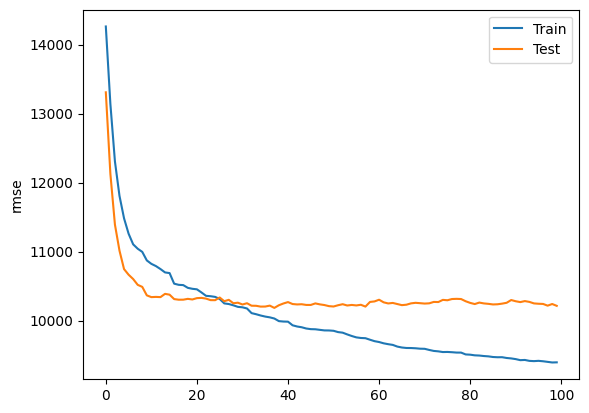

In [43]:
results = reg.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.legend()
plt.ylabel('rmse')
plt.show()

In [14]:
# Verificar el resultado con los datos de 2021 (test)

# Onehot
onehot_df_test = X_test[col_categoricas]
X_test_encoded = encoder.transform(onehot_df_test)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(col_categoricas), index=onehot_df_test.index)
X_test_drop = X_test.drop(col_categoricas, axis=1)
X_test = pd.concat([X_test_drop, X_test_encoded_df], axis=1)

# escalando las variables numéricas (Reentrenar scaler con todas las variables de train)
scaler.fit_transform(X_train[col_numericas])
X_test[col_numericas] = scaler.transform(X_test[col_numericas])

In [15]:
# Predict
y_pred = reg.predict(X_test)
print("\nTest:")
metricas(y_test, y_pred)


Test:
RMSE: 10901.87
R2 score: 0.36


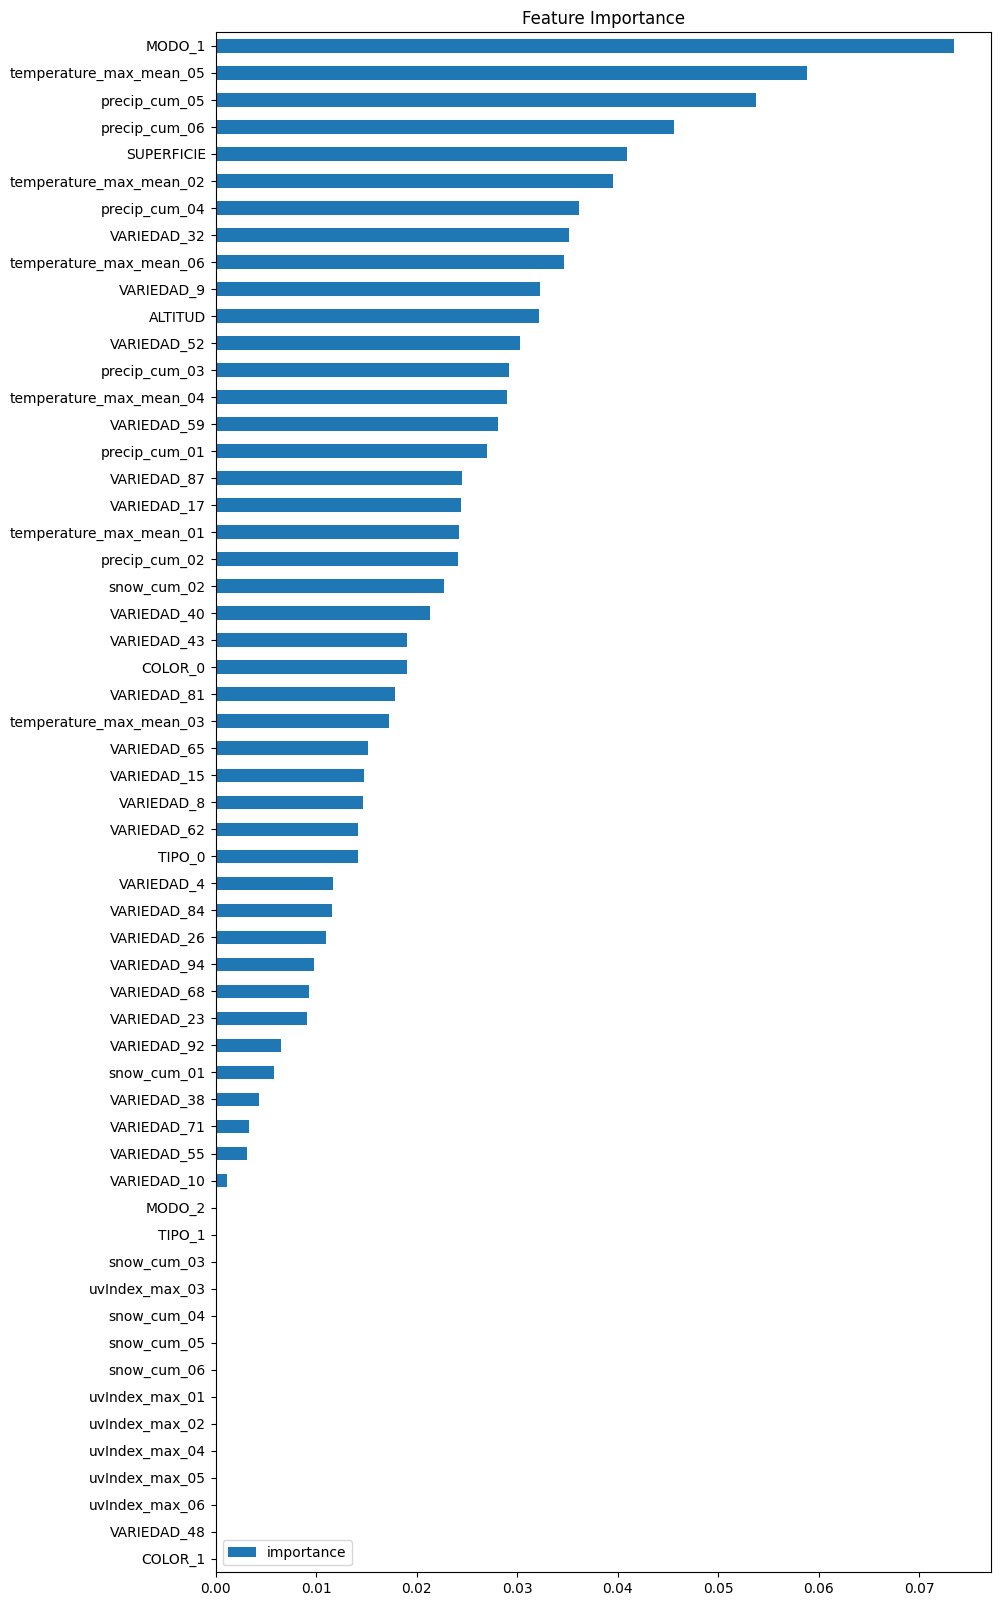

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi = fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(10,20))
plt.show()

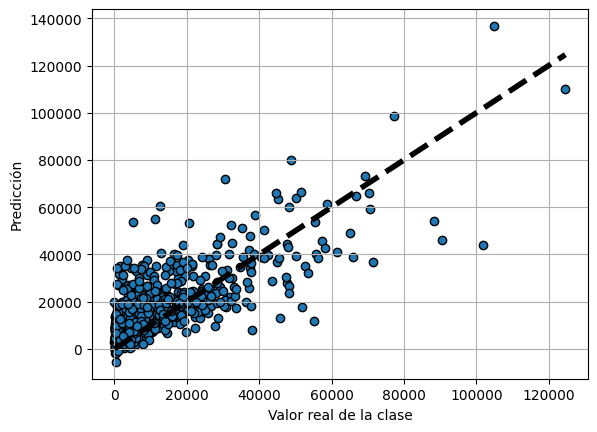

In [17]:
plot_bisectriz(y_test, y_pred)

## Repetir lo mismo pero con el fichero donde tenemos algunos valores de superficie añadidos 

[0]	validation_0-rmse:13476.20945	validation_1-rmse:11805.77412
[50]	validation_0-rmse:7164.10490	validation_1-rmse:8203.22271
[99]	validation_0-rmse:6542.73356	validation_1-rmse:8284.96387


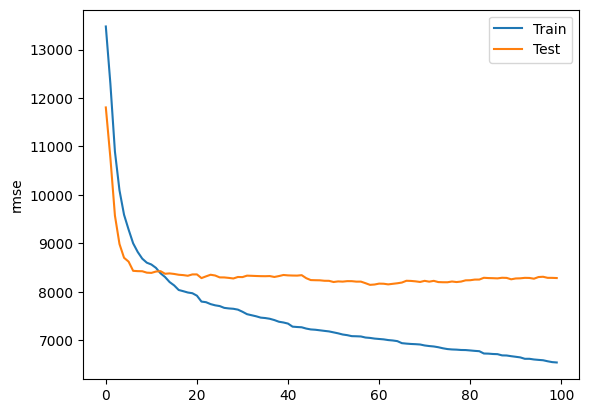

In [44]:
# Cargar datos de viñedos y temperatura
df_train = pd.read_csv('UH_2023_TRAIN_alt_sup.txt', sep="|")   # UH_2023_TRAIN_alt_sup
df_meteo = pd.read_csv('DATOS_METEO_MES.txt', sep="|")

# Unir datasets
df = pd.merge(df_train, df_meteo, on=['CAMPAÑA', 'ID_ESTACION'])

# Eliminar datos de 2022 (con estos se hara finalmente la prediccion final)
df = df[df['CAMPAÑA'] != 22]

# Separar datos de train y test (se usaran los datos de 2021 para el test)
df_train = df[df['CAMPAÑA'] != 21]
df_test = df[df['CAMPAÑA'] == 21]

# Separar X/y
X_train = df_train.drop(['PRODUCCION'], axis=1)
y_train = df_train['PRODUCCION']
X_test =  df_test.drop(['PRODUCCION'], axis=1)
y_test = df_test['PRODUCCION']

# Eliminar columnas no necesarias
X_train = X_train.drop(['CAMPAÑA', 'ID_ESTACION', 'ID_FINCA', 'ID_ZONA'], axis=1)
X_test = X_test.drop(['CAMPAÑA', 'ID_ESTACION', 'ID_FINCA', 'ID_ZONA'], axis=1)

# Normalizar datos
col_total = X_train.columns
lista_cat = ['VARIEDAD', 'MODO','TIPO','COLOR']
col_categoricas = [x for x in col_total if x in lista_cat]
col_numericas = [x for x in col_total if x not in lista_cat]

# One hot encoding
onehot_df_train = X_train[col_categoricas]
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(onehot_df_train)
X_train_encoded = encoder.transform(onehot_df_train)
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(col_categoricas))
X_train_drop = X_train.drop(col_categoricas, axis=1)
X_train = pd.concat([X_train_drop, X_train_encoded_df], axis=1)

# Split train y val
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)   # Por defecto es shuffle True

# escalando las variables numéricas
scaler=StandardScaler()
X_tr[col_numericas] = scaler.fit_transform(X_tr[col_numericas])
X_val[col_numericas] = scaler.transform(X_val[col_numericas])

# Definir y entrenar el modelo
reg = xgb.XGBRegressor(
    eval_metric = 'rmse',
    max_depth=5,
    min_child_weight=5,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42)

reg.fit(X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        verbose=50)

results = reg.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.legend()
plt.ylabel('rmse')
plt.show()

In [45]:
# Verificar el resultado con los datos de 2021 (test)

# Onehot
onehot_df_test = X_test[col_categoricas]
X_test_encoded = encoder.transform(onehot_df_test)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(col_categoricas), index=onehot_df_test.index)
X_test_drop = X_test.drop(col_categoricas, axis=1)
X_test = pd.concat([X_test_drop, X_test_encoded_df], axis=1)

# escalando las variables numéricas (Reentrenar scaler con todas las variables de train)
scaler.fit_transform(X_train[col_numericas])
X_test[col_numericas] = scaler.transform(X_test[col_numericas])

# Predict
y_pred = reg.predict(X_test)
print("\nTest:")
metricas(y_test, y_pred)


Test:
RMSE: 8356.43
R2 score: 0.62


## Repetir lo mismo pero añadiendo feature engineering: Produccion media por finca

[0]	validation_0-rmse:12950.67973	validation_1-rmse:11287.71251
[50]	validation_0-rmse:5461.17254	validation_1-rmse:6617.42920
[99]	validation_0-rmse:4961.58613	validation_1-rmse:6600.13722


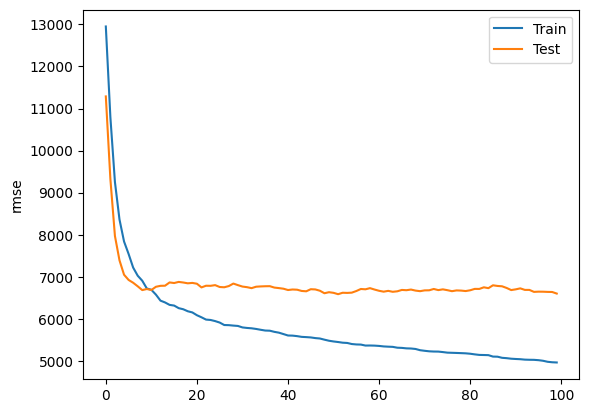

In [70]:
# Cargar datos de viñedos y temperatura
df_train = pd.read_csv('UH_2023_TRAIN_alt_sup.txt', sep="|")
df_meteo = pd.read_csv('DATOS_METEO_MES.txt', sep="|")

# Calcular la media de la produccion por finca. Usamos solo los datos anteriores a 2021 para respetar el test
suma_produccion = df_train[df_train['CAMPAÑA'] < 21 ].groupby('ID_FINCA')['PRODUCCION'].mean()
df_train['PRODUCCION_MEDIA'] = df_train['ID_FINCA'].map(suma_produccion)

# Unir datasets
df = pd.merge(df_train, df_meteo, on=['CAMPAÑA', 'ID_ESTACION'])

# Eliminar datos de 2022 (con estos se hara finalmente la prediccion final)
df = df[df['CAMPAÑA'] != 22]

# Separar datos de train y test (se usaran los datos de 2021 para el test)
df_train = df[df['CAMPAÑA'] != 21]
df_test = df[df['CAMPAÑA'] == 21]

# Separar X/y
X_train = df_train.drop(['PRODUCCION'], axis=1)
y_train = df_train['PRODUCCION']
X_test =  df_test.drop(['PRODUCCION'], axis=1)
y_test = df_test['PRODUCCION']

# Eliminar columnas no necesarias
X_train = X_train.drop(['CAMPAÑA', 'ID_ESTACION', 'ID_FINCA', 'ID_ZONA'], axis=1)
X_test = X_test.drop(['CAMPAÑA', 'ID_ESTACION', 'ID_FINCA', 'ID_ZONA'], axis=1)

# Normalizar datos
col_total = X_train.columns
lista_cat = ['VARIEDAD', 'MODO','TIPO','COLOR']
col_categoricas = [x for x in col_total if x in lista_cat]
col_numericas = [x for x in col_total if x not in lista_cat]

# One hot encoding
onehot_df_train = X_train[col_categoricas]
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(onehot_df_train)
X_train_encoded = encoder.transform(onehot_df_train)
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(col_categoricas))
X_train_drop = X_train.drop(col_categoricas, axis=1)
X_train = pd.concat([X_train_drop, X_train_encoded_df], axis=1)

# Split train y val
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)   # Por defecto es shuffle True

# escalando las variables numéricas
scaler=StandardScaler()
X_tr[col_numericas] = scaler.fit_transform(X_tr[col_numericas])
X_val[col_numericas] = scaler.transform(X_val[col_numericas])

# Definir y entrenar el modelo
reg = xgb.XGBRegressor(
    eval_metric = 'rmse',
    max_depth=3,
    min_child_weight=10,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42)

reg.fit(X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        verbose=50)

results = reg.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.legend()
plt.ylabel('rmse')
plt.show()

In [71]:
# Verificar el resultado con los datos de 2021 (test)

# Onehot
onehot_df_test = X_test[col_categoricas]
X_test_encoded = encoder.transform(onehot_df_test)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(col_categoricas), index=onehot_df_test.index)
X_test_drop = X_test.drop(col_categoricas, axis=1)
X_test = pd.concat([X_test_drop, X_test_encoded_df], axis=1)

# escalando las variables numéricas (Reentrenar scaler con todas las variables de train)
scaler.fit_transform(X_train[col_numericas])
X_test[col_numericas] = scaler.transform(X_test[col_numericas])

# Predict
y_pred = reg.predict(X_test)
print("\nTest:")
metricas(y_test, y_pred)


Test:
RMSE: 6895.86
R2 score: 0.74


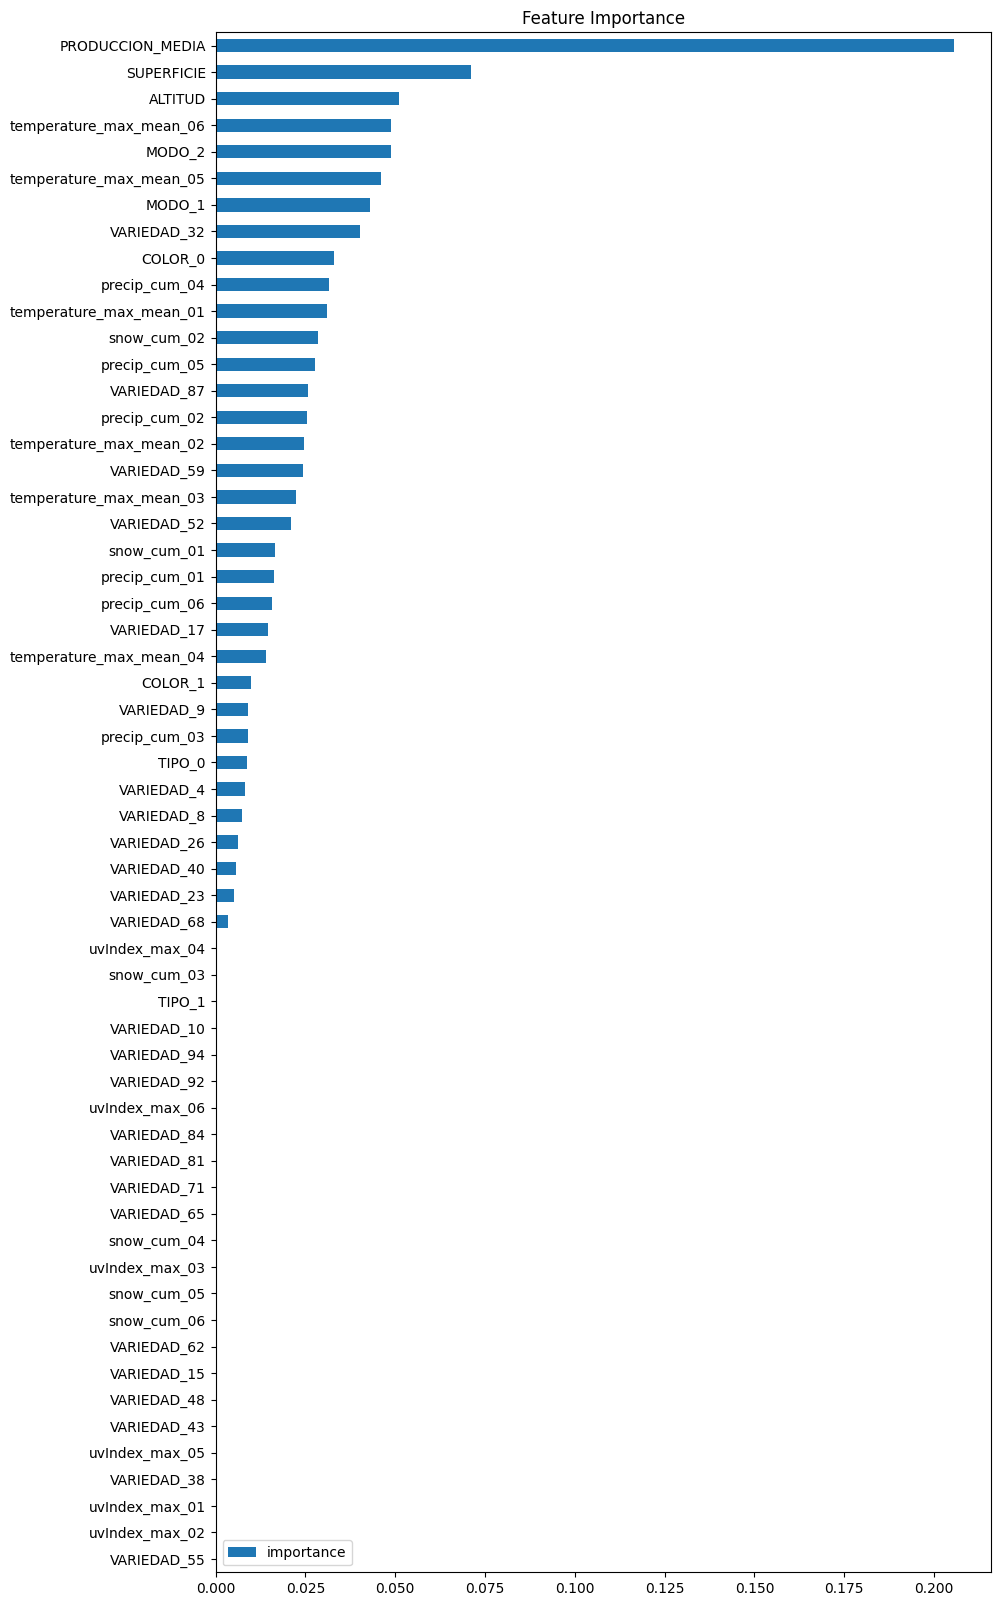

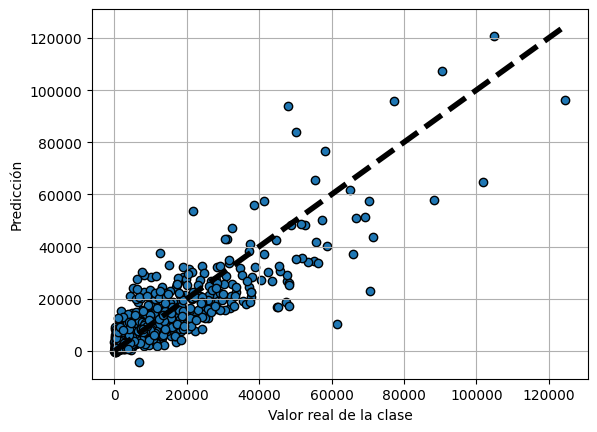

In [72]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi = fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(10,20))
plt.show()

plot_bisectriz(y_test, y_pred)


## Repetir lo mismo pero añadiendo otra feature engineering: Rendimiento (Kg/ha)

[0]	validation_0-rmse:12955.25873	validation_1-rmse:11277.64793
[50]	validation_0-rmse:4208.37615	validation_1-rmse:4943.10761
[99]	validation_0-rmse:3701.51050	validation_1-rmse:4783.62287


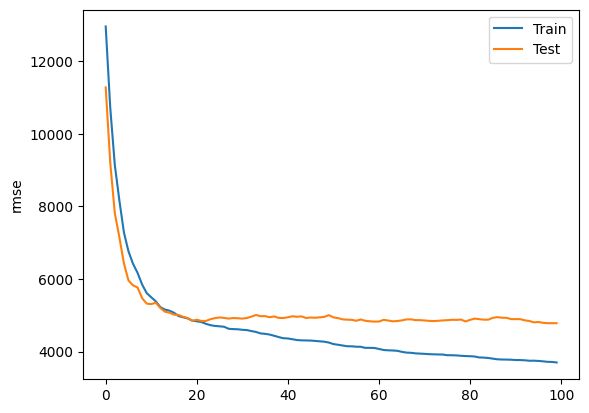

In [73]:
# Cargar datos de viñedos y temperatura
df_train = pd.read_csv('UH_2023_TRAIN_alt_sup.txt', sep="|")
df_meteo = pd.read_csv('DATOS_METEO_MES.txt', sep="|")

# Calcular la media de la produccion por finca. Usamos solo los datos anteriores a 2021 para respetar el test
suma_produccion = df_train[df_train['CAMPAÑA'] < 21 ].groupby('ID_FINCA')['PRODUCCION'].mean()
df_train['PRODUCCION_MEDIA'] = df_train['ID_FINCA'].map(suma_produccion)

# Añadir rendimiento
df_train['RENDIMIENTO'] = df_train['PRODUCCION'] / df_train['SUPERFICIE']

# Unir datasets
df = pd.merge(df_train, df_meteo, on=['CAMPAÑA', 'ID_ESTACION'])

# Eliminar datos de 2022 (con estos se hara finalmente la prediccion final)
df = df[df['CAMPAÑA'] != 22]

# Separar datos de train y test (se usaran los datos de 2021 para el test)
df_train = df[df['CAMPAÑA'] != 21]
df_test = df[df['CAMPAÑA'] == 21]

# Separar X/y
X_train = df_train.drop(['PRODUCCION'], axis=1)
y_train = df_train['PRODUCCION']
X_test =  df_test.drop(['PRODUCCION'], axis=1)
y_test = df_test['PRODUCCION']

# Eliminar columnas no necesarias
X_train = X_train.drop(['CAMPAÑA', 'ID_ESTACION', 'ID_FINCA', 'ID_ZONA'], axis=1)
X_test = X_test.drop(['CAMPAÑA', 'ID_ESTACION', 'ID_FINCA', 'ID_ZONA'], axis=1)

# Normalizar datos
col_total = X_train.columns
lista_cat = ['VARIEDAD', 'MODO','TIPO','COLOR']
col_categoricas = [x for x in col_total if x in lista_cat]
col_numericas = [x for x in col_total if x not in lista_cat]

# One hot encoding
onehot_df_train = X_train[col_categoricas]
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(onehot_df_train)
X_train_encoded = encoder.transform(onehot_df_train)
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(col_categoricas))
X_train_drop = X_train.drop(col_categoricas, axis=1)
X_train = pd.concat([X_train_drop, X_train_encoded_df], axis=1)

# Split train y val
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)   # Por defecto es shuffle True

# escalando las variables numéricas
scaler=StandardScaler()
X_tr[col_numericas] = scaler.fit_transform(X_tr[col_numericas])
X_val[col_numericas] = scaler.transform(X_val[col_numericas])

# Definir y entrenar el modelo
reg = xgb.XGBRegressor(
    eval_metric = 'rmse',
    max_depth=3,
    min_child_weight=10,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42)

reg.fit(X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        verbose=50)

results = reg.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.legend()
plt.ylabel('rmse')
plt.show()

In [75]:
#Verificar el resultado con los datos de 2021 (test)

# Onehot
onehot_df_test = X_test[col_categoricas]
X_test_encoded = encoder.transform(onehot_df_test)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(col_categoricas), index=onehot_df_test.index)
X_test_drop = X_test.drop(col_categoricas, axis=1)
X_test = pd.concat([X_test_drop, X_test_encoded_df], axis=1)

# escalando las variables numéricas (Reentrenar scaler con todas las variables de train)
scaler.fit_transform(X_train[col_numericas])
X_test[col_numericas] = scaler.transform(X_test[col_numericas])

# Predict
y_pred = reg.predict(X_test)
print("\nTest:")
metricas(y_test, y_pred)


Test:
RMSE: 3120.25
R2 score: 0.95


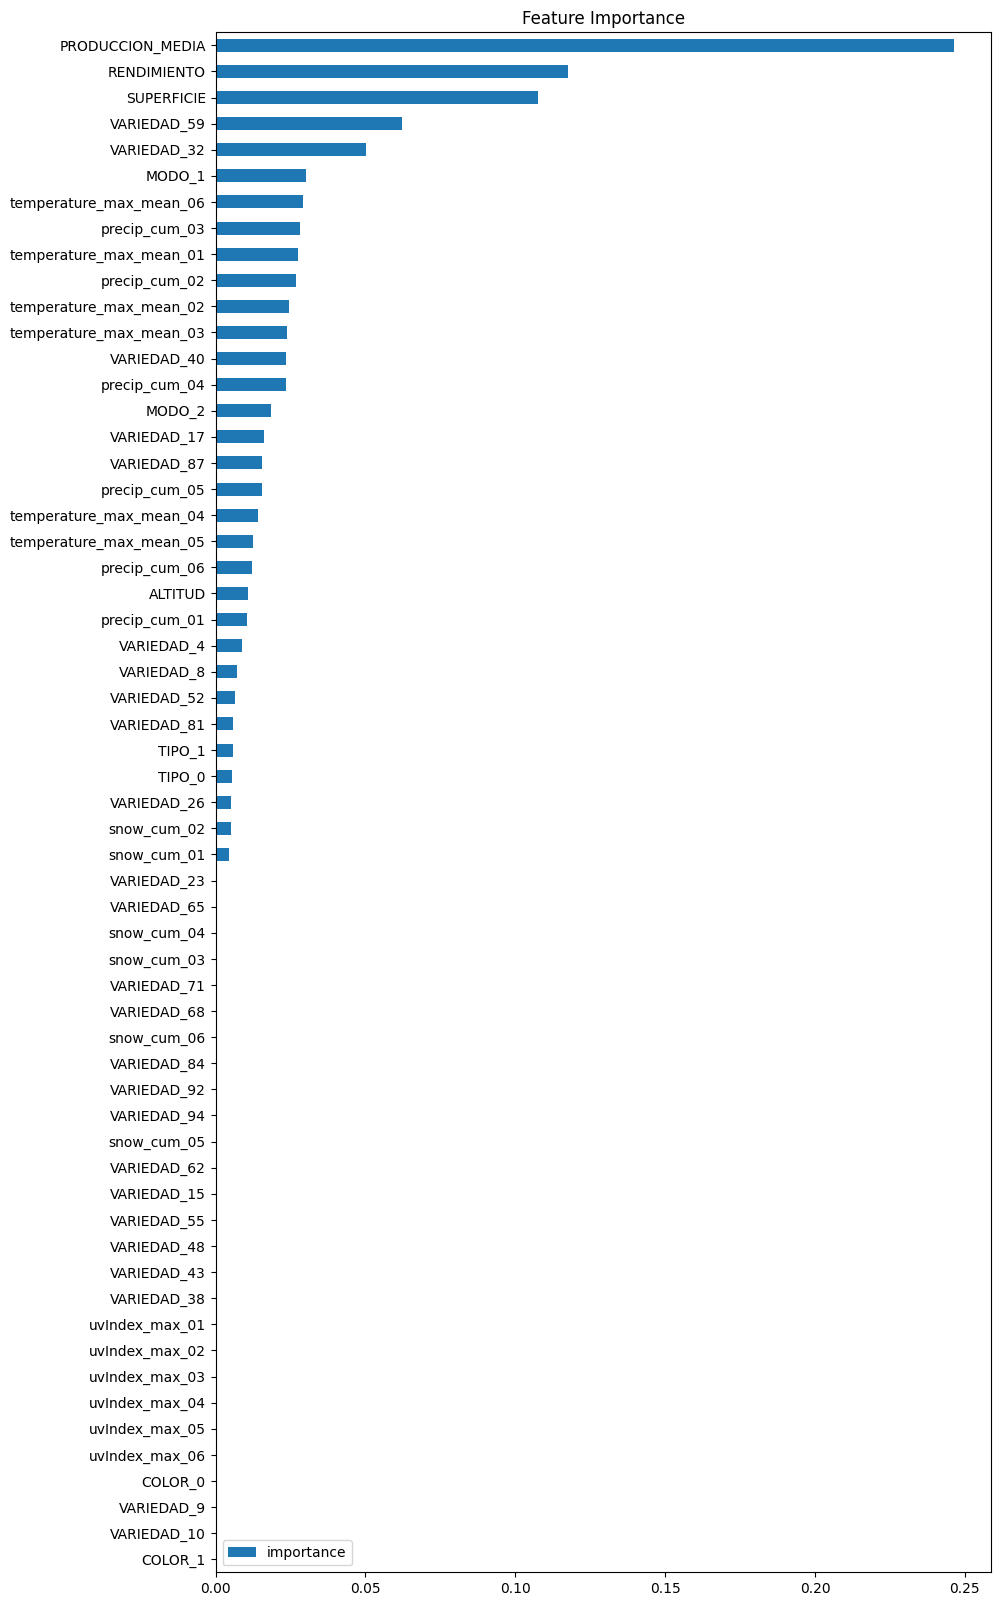

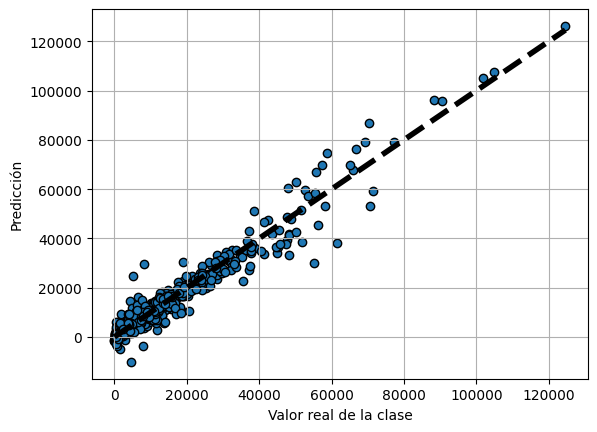

In [76]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi = fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(10,20))
plt.show()

plot_bisectriz(y_test, y_pred)